Zixuan Chen 61665307

# Problem 1

## a. write a 1D black box unconstrained function optimizer

The algorithm of "initial_min_bracket" is translated from the Kochenderfer and Wheeler book (pg.36) Algorithm 3.1, "bracket_minimum".

In [3]:
def initial_min_bracket(f, start = 0, var_a = 2, step = 1e-2, expand_factor = 2.0):
    ''' return the initial bracket and the number of function evaluations'''
    a, fa = start, f(start, var_a)
    b, fb = start + step, f(start + step, var_a)
    n_func = 2 # starting with 2 function evaluation 
    # change direction if we start at an uphill
    if fb > fa:
        a, b = b, a
        fa, fb = fb, fa
        step = -step
    # take a step each time.
    # if the next step has a larger value, it indicates that we have just stepped over a local minima
    # otherwise, largen the step by an expand factor and then move on
    while True:
        c, fc = b + step, f(b + step, var_a); n_func += 1
        if fc > fb:
            return (a, c, n_func) if a <= c else (c, a, n_func)
        a, fa, b, fb = b, fb, c, fc
        step *= expand_factor

The algorithm  of "optimizer1D" is translated and modified from the Kochenderfer and Wheeler book (pg.41) Algorithm 3.3, "golden_section_search".\
It combines with the previously defined initial_min_bracket and outputs the optimized result with other useful information such as convergence measure, number of function evaluation and running time.\
The idea of the parameter "tolerance" comes from the Belegundu and Chandrupatla book (pg.65). It indicates that the loop will stop once the interval's size shrinks to the tolerance value.

In [4]:
# import libs and define constants 
import time
import matplotlib.pyplot as plt
import numpy as np
Phi = (1 + np.sqrt(5))/2

def optimizer1D(func, initial_point = 0, var_a = 2, initial_step_size = 1e-2, tolerance = 1e-4):
    # optimization method used = golden section search
    # source(s) of code used = Algorithms for Optimization by Kochenderfer and Wheeler. pg.36 and 41
    
    # start a clock
    start_clock = time.perf_counter()
    # obtain the initial bracket [a,b] and number of function evaluations
    a, b, n_func = initial_min_bracket(func, initial_point, var_a, initial_step_size)
    
    # Golden Section Search
    phi = Phi - 1
    # initially, values are ordered as a,c,d,b on the x-axis
    # maintain the raito inside of the interval; (d - a)/(b - a) = phi = (b - c)/(b - a)
    d = phi * (b - a) + a  
    fd = func(d, var_a); n_func += 1
    
    convergence_measure = 0 # keep track of the convergence
    # until the stopping criterion is satisfied, compare f(c) with f(d) and truncate the part which has higher function value
    while abs(b - a) > tolerance:
        c = b - phi * (b - a) 
        fc = func(c, var_a); n_func += 1
        # c - a = b - d; thus, we are tracking the distance which will be truncated in this iteration
        convergence_measure = abs(c - a)
        if fc < fd:
            b, d, fd = d, c, fc  # truncate (d, b)
        else:
            a, b = b, c # truncate (a, c)

    elapsed = time.perf_counter() - start_clock
    return (convergence_measure, (a + b)/2, n_func, elapsed)

## b. choose 100 random starting points

In [5]:
np.random.seed(0) # for convenience, I will let random produces the same N every time
sign = [-1, 1]
N = [np.random.choice(sign) * np.exp(np.random.uniform(-10.0,10.0)) for _ in range(100)]
print("Peek the values in N (first and last 5):")
print(N[:5],'\n...\n',N[95:])

Peek the values in N (first and last 5):
[-6.403805125184307, -7.808926648473528, 1037.983093148718, 18.50206340616654, -0.017434437377164116] 
...
 [2536.31393757198, 2.096879794169812, 0.00033698833119214807, -0.052142924848608406, -21524.34999918602]


## c. optimize

Creating the following functions\
f(x, a) = 1/2 * (x − a)^2\
g(x, a) = 1/4 * x^4 − a*x\
h(x, a) = e^x + e^−x − a*x\
a = 2

In [6]:
f = lambda x, a = 2: .5*(x - a)**2
g = lambda x, a = 2: .25*x**4 - a*x
'''
Some starting points from N are huge for the exponential function, which would cause overflows and make the program crash. 
therefore I choose to approximate exp(x) by taking its Taylor expansion with the first 7 terms.
Near the minimum point, the Taylor version will be almost the same as the original, so it would not ruin the result 
'''
from math import factorial
def my_exp(x,n = 8):
    return sum((x**i)/factorial(i) for i in range(n))

h = lambda x, a = 2: my_exp(x) + my_exp(-x) - a*x

Here I am computing the actual minmimun by taking (by hand) the first partial derivate for f, g and h and set them equals to 0

In [7]:
'''
    df/dx = a - x = 0
        x = a 
    dg/dx = x^3 - a = 0
        x = a^(1/3)
    dh/dx = e^x - e^-x - a = 0
        y - 1/y = a | y = e^x
        y^2 - ay -1 = 0 | y = e^x
        y = (a + sqrt(a^2 + 4))/2 | y = e^x
        x = ln((a + sqrt(a^2 + 4))/2)
'''
a = 2.0
f_min = a
g_min = a**(1/3)
h_min = np.log((a + np.sqrt(a**2 + 4)) / 2) 
actual_values = [f_min, g_min, h_min]
print('Actual minimum points are', actual_values, 'for f, g and h respectively when a = 2')

Actual minimum points are [2.0, 1.2599210498948732, 0.8813735870195429] for f, g and h respectively when a = 2


In [20]:
# run optimizer1D over N = 100 starting points for f, g and h respectively
result = np.array([[optimizer1D(j, initial_point = i) for i in N] for j in [f, g, h]])
# compute and update the actual absolute value of error for all 
for estimates, real in zip(result, actual_values):
    for i in estimates:
        i[1] = abs(real - i[1])

# report in 3*4 table
from beautifultable import BeautifulTable
table = BeautifulTable()
table.column_headers = ["functions", "Convergence Measure", "|error|", "#of function evaluation", "time"]
for i, j in zip(result, ['f(x,2)', 'g(x,2)', 'h(x,2)']): # for each function
    table_row = [j]
    for t in range(4):       # for rech result
        m = np.mean(i[:,t])  # sample mean
        s = np.sqrt(sum([(k - m)**2 for k in i[:,t]]) / 99) # unbiased estimate of population std
        table_row.append('{:.3e} +/- {:.3e}'.format(m,s))
    table.append_row(table_row)
print(table)

+--------------+---------------+---------------+---------------+---------------+
|  functions   | Convergence M |    |error|    | #of function  |     time      |
|              |    easure     |               |  evaluation   |               |
+--------------+---------------+---------------+---------------+---------------+
|    f(x,2)    | 5.259e-05 +/- | 1.192e-05 +/- | 4.098e+01 +/- | 6.128e-05 +/- |
|              |   7.471e-06   |   7.763e-06   |   1.074e+01   |   3.281e-05   |
+--------------+---------------+---------------+---------------+---------------+
|    g(x,2)    | 4.766e-05 +/- | 1.144e-05 +/- | 4.015e+01 +/- | 6.862e-05 +/- |
|              |   5.182e-06   |   6.671e-06   |   1.122e+01   |   3.819e-05   |
+--------------+---------------+---------------+---------------+---------------+
|    h(x,2)    | 4.479e-05 +/- | 5.610e-05 +/- | 3.936e+01 +/- | 5.605e-04 +/- |
|              |   6.595e-06   |   1.171e-05   |   1.186e+01   |   2.264e-04   |
+--------------+------------

The table above reports the sample means and estimated population standard deviations over 100 runs for three test functions respectively. Each row represent a function and each column represent an information that I kept track of during the runs.\
It shows that my optimizer did very good estimates by keeping the absolute error less than 1e-4, and the time tells that it can find a minima very quickly.

## Extra Credit

For this problem, I will gradually increase the tolerance threshold, which I held constant in previous problem, and run optimize1D over the same N = 100 starting point for each function respectively.\
This time I only pay attention to the relation between the convergence measure and the tolerance.

Sample mean of Convergence Measure(Y-axis) over Tolerance(X-axis) for f(x,2)


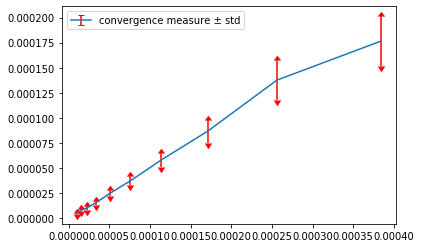

Sample mean of Convergence Measure(Y-axis) over Tolerance(X-axis) for g(x,2)


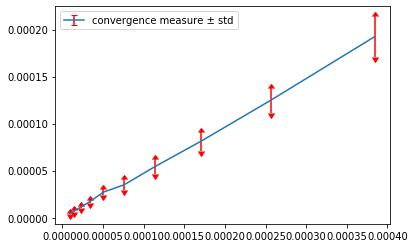

Sample mean of Convergence Measure(Y-axis) over Tolerance(X-axis) for h(x,2)


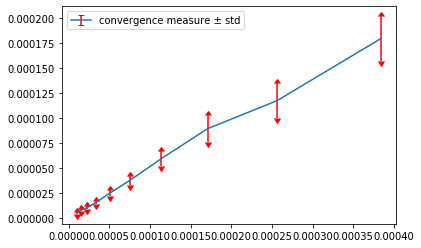

In [7]:
tol = [1e-5 * 1.5**i for i in range(10)]
for func, f_name in zip([f, g, h], ['f(x,2)', 'g(x,2)', 'h(x,2)']):
    mean, std = [], []
    for t in tol:
        y = [optimizer1D(func, initial_point = x, tolerance = t)[0] for x in N]  # [convergence measure]
        mean.append(np.mean(y))   # sample mean 
        std.append(np.sqrt(sum([(k - np.mean(y))**2 for k in y]) / 99)) # unbiased estimate of population std 
    print('Sample mean of Convergence Measure(Y-axis) over Tolerance(X-axis) for', f_name)
    plt.errorbar(tol, mean, yerr = std, ecolor = 'red', uplims=True, lolims=True, label = 'convergence measure ± std')
    plt.legend()
    plt.show()

According to the data plots, as the tolerance value grows from 1e-5 to 4e-4, the convergence measure grows at a faster rate (40x change in x but over 100x change in y). Meanwhile, the standard deviation also grows. Thus, there is an proportional relation.